# STADVDVBVBDBVBDBVDB MCO1

In [4]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine, text

import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings

In [5]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Database Connection Setup
as per Yazan's machine and server.

In [ ]:
# MySQL Connection Details 

username = "root"
password = "admin"
host = "localhost"
port = "3306"
database = "stadvdb_imdb"

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

try:
    with engine.connect() as conn:
        tables = pd.read_sql("SHOW TABLES;", conn)
    print("Successfully connected to the database!")
    display(tables)
except Exception as e:
    print("Connection failed:", e)

# Service Tool

This will be the notebook's "backend". The goal is to have a clean set of code cells that define one Python function for each of our features. We should be able to run these cells and use our tool. Unless I somehow messed up my groupmate's queries... then it's a gg

## Movie Search

In [ ]:
# Movie Search

def combined_search(keyword=None, genre=None, min_rating=None, max_rating=None, min_votes=None):
    select_clause = "SELECT m.tconst, m.primaryTitle AS title, r.averageRating, r.numVotes"
    from_clause = "FROM dim_movie AS m JOIN title_ratings AS r ON m.tconst = r.tconst"
    join_clauses = []
    where_clauses = []
    params = {}
    
    if keyword:
        where_clauses.append("MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE)")
        params["keyword"] = keyword
        
    if genre:
        join_clauses.append("JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst")
        join_clauses.append("JOIN genre_dt AS g ON tg.genreID = g.genreID")
        where_clauses.append("g.genreName = :genre")
        params["genre"] = genre
        
    if min_rating:
        where_clauses.append("r.averageRating >= :min_r")
        params["min_r"] = min_rating
        
    if max_rating:
        where_clauses.append("r.averageRating <= :max_r")
        params["max_r"] = max_rating
        
    if min_votes:
        where_clauses.append("r.numVotes >= :min_v")
        params["min_v"] = min_votes
        
    query = select_clause + " " + from_clause
    
    if join_clauses:
        query += " " + " ".join(join_clauses)
        
    if where_clauses:
        query += " WHERE " + " AND ".join(where_clauses)
        
    query += " ORDER BY r.averageRating DESC"
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(text(query), conn, params=params)
        end = time.time()
    
    print(f"Combined search executed in {end - start:.3f} seconds, returning {len(df)} rows.")
    return df

In [12]:
# Cosine Similarity Helper Components

def get_vector_components(engine):
    stats_query = """
        SELECT 
            MIN(averageRating) AS min_rating, MAX(averageRating) AS max_rating,
            MIN(numVotes) AS min_votes, MAX(numVotes) AS max_votes,
            MIN(runtimeMinutes) AS min_runtime, MAX(runtimeMinutes) AS max_runtime
        FROM title_ft
        WHERE numVotes > 1000; 
    """
    with engine.connect() as conn:
        stats = pd.read_sql(stats_query, conn).iloc[0]

    genres_query = "SELECT genreID, genreName FROM genre_dt;"
    with engine.connect() as conn:
        genres_df = pd.read_sql(genres_query, conn)

    numerical_features = [
        ("norm_rating", f"((t.averageRating - {stats['min_rating']}) / ({stats['max_rating']} - {stats['min_rating']}))"),
        ("norm_votes", f"((t.numVotes - {stats['min_votes']}) / ({stats['max_votes']} - {stats['min_votes']}))"),
        ("norm_runtime", f"((t.runtimeMinutes - {stats['min_runtime']}) / ({stats['max_runtime']} - {stats['min_runtime']}))")
    ]
    
    genre_features = []
    for _, row in genres_df.iterrows():
        col_name = f"genre_{row['genreName'].replace('-', '_').replace(' ', '_')}"
        sql_case = f"MAX(CASE WHEN g.genreID = {row['genreID']} THEN 1 ELSE 0 END) AS {col_name}"
        genre_features.append((col_name, sql_case))

    all_features = numerical_features + genre_features
    feature_names = [name for name, sql in all_features]
    
    dot_product_sql = " + ".join([f"A.{name} * B.{name}" for name in feature_names])
    magnitude_A_sql = f"SQRT(" + " + ".join([f"A.{name} * A.{name}" for name in feature_names]) + ")"
    magnitude_B_sql = f"SQRT(" + " + ".join([f"B.{name} * B.{name}" for name in feature_names]) + ")"
    
    return dot_product_sql, magnitude_A_sql, magnitude_B_sql

try:
    dot_product_sql, magnitude_A_sql, magnitude_B_sql = get_vector_components(engine)
    print("Cosine Similarity helper components built successfully.")
except Exception as e:
    print(f"Error building Cosine Similarity components: {e}")
    print("WARNING: find_similar_movies() will not work.")

Cosine Similarity helper components built successfully.


In [ ]:
# Cosine Similarity Function

def find_similar_movies(tconst):
    query = text(f"""
        WITH TargetMovie AS (
            SELECT * FROM movie_feature_vector_materialized WHERE tconst = :tconst
        )
        SELECT 
            B.tconst,
            B.primaryTitle,
            CASE 
                WHEN ({magnitude_A_sql}) = 0 OR ({magnitude_B_sql}) = 0 THEN 0
                ELSE ({dot_product_sql}) / (({magnitude_A_sql}) * ({magnitude_B_sql}))
            END AS cosine_similarity
        FROM 
            TargetMovie A
        CROSS JOIN 
            movie_feature_vector_materialized B -- Querying the fast table
        WHERE 
            A.tconst != B.tconst
        ORDER BY 
            cosine_similarity DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"tconst": tconst})
        end = time.time()
    
    print(f"Similarity query executed in {end - start:.3f} seconds, returning {len(df)} rows.")
    return df

print("Movie Search loaded succesfully.")

Movie Search loaded succesfully.


## Director Search

In [16]:
# Director Search

def get_best_directors(genre=None, profession=None, living_only=False):
    select_clause = """
        SELECT
            d.nconst,
            d.PrimaryName,
            COUNT(DISTINCT tdr.tconst) AS totalMovies,
            AVG(r.averageRating) AS avgRating,
            SUM(r.numVotes) AS totalVotes,
            (AVG(r.averageRating) * (SUM(r.numVotes) / 1000)) AS weightedScore -- JM's weighted score
    """
    
    from_clause = """
        FROM directors_dt AS d
        JOIN title_director_bridge AS tdr ON d.nconst = tdr.nconst
        JOIN title_ratings AS r ON tdr.tconst = r.tconst
    """
    
    join_clauses = []
    where_clauses = []
    params = {}
    
    if profession:
        join_clauses.append("""
            JOIN director_profession_bridge AS dpb ON d.nconst = dpb.nconst
            JOIN profession_dt AS p ON dpb.professionID = p.professionID
        """)
        where_clauses.append("p.professionName = :prof")
        params["prof"] = profession
        
    if genre:
        join_clauses.append("""
            JOIN title_genre_bridge AS tgb ON r.tconst = tgb.tconst
            JOIN genre_dt AS g ON tgb.genreID = g.genreID
        """)
        where_clauses.append("g.genreName = :genre")
        params["genre"] = genre
        
    if living_only:
        where_clauses.append("d.deathYear IS NULL")
        
    query = select_clause + " " + from_clause + " " + " ".join(join_clauses)
    
    if where_clauses:
        query += " WHERE " + " AND ".join(where_clauses)
        
    query += """
        GROUP BY d.nconst, d.PrimaryName
        HAVING totalMovies > 5 -- A filter to get established directors
        ORDER BY weightedScore DESC
    """
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(text(query), conn, params=params)
        end = time.time()
    
    print(f"Director search executed in {end - start:.3f} seconds, returning {len(df)} rows.")
    return df

In [17]:
def get_director_profession_comparison():
    writer_query = text("""
        SELECT 
            CASE 
                WHEN d.nconst IN (
                    SELECT nconst 
                    FROM director_profession_bridge dpb 
                    JOIN profession_dt p ON dpb.professionID = p.professionID 
                    WHERE p.professionName = 'writer'
                ) THEN 'Writer-Director' 
                ELSE 'Director Only' 
            END AS directorType,
            AVG(r.averageRating) AS avgRating,
            COUNT(DISTINCT d.nconst) AS numDirectors
        FROM directors_dt d
        JOIN title_director_bridge tdb ON d.nconst = tdb.nconst
        JOIN title_ratings r ON tdb.tconst = r.tconst
        GROUP BY directorType;
    """)
    
    music_query = text("""
        SELECT 
            CASE 
                WHEN d.nconst IN (
                    SELECT nconst 
                    FROM director_profession_bridge dpb 
                    JOIN profession_dt p ON dpb.professionID = p.professionID 
                    WHERE p.professionName = 'music_department'
                ) THEN 'Music-Director' 
                ELSE 'Director Only' 
            END AS directorType,
            AVG(r.averageRating) AS avgRating,
            COUNT(DISTINCT d.nconst) AS numDirectors
        FROM directors_dt d
        JOIN title_director_bridge tdb ON d.nconst = tdb.nconst
        JOIN title_ratings r ON tdb.tconst = r.tconst
        GROUP BY directorType;
    """)
    
    with engine.connect() as conn:
        print("Running profession comparison queries...")
        start = time.time()
        writer_df = pd.read_sql(writer_query, conn)
        music_df = pd.read_sql(music_query, conn)
        end = time.time()
        print(f"Comparison queries executed in {end - start:.3f} seconds.")
    
    return writer_df, music_df

print("Director Search loaded.")

Director Search loaded.


## Genre Analytics

In [18]:
# Genre Analytics
def get_genre_trends_over_time():
    query = text("""
        SELECT 
            t.startYear,
            AVG(r.averageRating) AS avg_rating,
            AVG(r.numVotes) AS avg_numVotes,
            AVG(t.runtimeMinutes) AS avg_runtime
        FROM title_ft AS t
        JOIN title_ratings AS r ON t.tconst = r.tconst
        WHERE t.startYear IS NOT NULL 
          AND t.runtimeMinutes IS NOT NULL
        GROUP BY t.startYear
        ORDER BY t.startYear;
    """)
    
    with engine.connect() as conn:
        print("Fetching genre trends over time...")
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
        print(f"Genre trends query executed in {end - start:.3f} seconds, returning {len(df)} rows.")
        
    return df


In [21]:
def get_top_movies_by_decade(decade_start):
    decade_end = decade_start + 9
    
    query = text("""
        SELECT 
            t.primaryTitle,
            t.startYear,
            r.averageRating,
            r.numVotes
        FROM title_ft AS t
        JOIN title_ratings AS r ON t.tconst = r.tconst
        WHERE t.startYear BETWEEN :start AND :end
        ORDER BY r.averageRating DESC, r.numVotes DESC;
    """)
    
    with engine.connect() as conn:
        print(f"Fetching all movies for {decade_start}-{decade_end}...")
        start = time.time()
        df = pd.read_sql(query, conn, params={"start": decade_start, "end": decade_end})
        end = time.time()
        print(f"Top movies query executed in {end - start:.3f} seconds, returning {len(df)} rows.")
        
    return df

In [22]:
def get_genre_proportions_by_decade():
    query = text("""
        WITH DecadeGenres AS (
            SELECT 
                FLOOR(t.startYear / 10) * 10 AS decade,
                g.genreName,
                COUNT(t.tconst) AS movie_count
            FROM title_ft t
            JOIN title_genre_bridge tgb ON t.tconst = tgb.tconst
            JOIN genre_dt g ON tgb.genreID = g.genreID
            WHERE t.startYear IS NOT NULL
            GROUP BY decade, g.genreName
        ),
        TotalPerDecade AS (
            SELECT 
                decade,
                SUM(movie_count) AS total_count
            FROM DecadeGenres
            GROUP BY decade
        )
        -- PIVOT the data to show proportions
        SELECT
            dg.genreName,
            SUM(CASE WHEN dg.decade = 1870 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1870s',
            SUM(CASE WHEN dg.decade = 1880 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1880s',
            SUM(CASE WHEN dg.decade = 1890 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1890s',
            SUM(CASE WHEN dg.decade = 1900 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1900s',
            SUM(CASE WHEN dg.decade = 1910 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1910s',
            SUM(CASE WHEN dg.decade = 1920 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1920s',
            SUM(CASE WHEN dg.decade = 1930 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1930s',
            SUM(CASE WHEN dg.decade = 1940 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1940s',
            SUM(CASE WHEN dg.decade = 1950 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1950s',
            SUM(CASE WHEN dg.decade = 1960 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1960s',
            SUM(CASE WHEN dg.decade = 1970 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1970s',
            SUM(CASE WHEN dg.decade = 1980 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1980s',
            SUM(CASE WHEN dg.decade = 1990 THEN dg.movie_count / td.total_count ELSE 0 END) AS '1990s',
            SUM(CASE WHEN dg.decade = 2000 THEN dg.movie_count / td.total_count ELSE 0 END) AS '2000s',
            SUM(CASE WHEN dg.decade = 2010 THEN dg.movie_count / td.total_count ELSE 0 END) AS '2010s',
            SUM(CASE WHEN dg.decade = 2020 THEN dg.movie_count / td.total_count ELSE 0 END) AS '2020s'
        FROM DecadeGenres dg
        JOIN TotalPerDecade td ON dg.decade = td.decade
        GROUP BY dg.genreName
        ORDER BY dg.genreName;
    """)
    
    with engine.connect() as conn:
        print("Calculating genre proportions by decade (PIVOT)...")
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
        print(f"Genre proportions query executed in {end - start:.3f} seconds, returning {len(df)} rows.")
        
    return df

print("Genre Analytics loaded.")

Genre Analytics loaded.


## Statistical Tool

In [23]:
# Statistical Tool (if thats what this section is called)

def get_movie_zscore(tconst, genre):
    query = text("""
        WITH GenreStats AS (
            SELECT 
                AVG(r.averageRating) AS avg_rating,
                STDDEV(r.averageRating) AS stddev_rating,
                AVG(r.numVotes) AS avg_votes,
                STDDEV(r.numVotes) AS stddev_votes
            FROM title_ratings r
            JOIN title_genre_bridge tgb ON r.tconst = tgb.tconst
            JOIN genre_dt g ON tgb.genreID = g.genreID
            WHERE g.genreName = :genre
        ),
        MovieStats AS (
            SELECT 
                r.averageRating,
                r.numVotes
            FROM title_ratings r
            WHERE r.tconst = :tconst
        )
        SELECT 
            m.averageRating,
            m.numVotes,
            g.avg_rating,
            g.stddev_rating,
            g.avg_votes,
            g.stddev_votes,
            (m.averageRating - g.avg_rating) / g.stddev_rating AS z_score_rating,
            (m.numVotes - g.avg_votes) / g.stddev_votes AS z_score_votes
        FROM MovieStats m, GenreStats g;
    """)
    
    with engine.connect() as conn:
        print(f"Calculating Z-Score for {tconst} in {genre}...")
        start = time.time()
        df = pd.read_sql(query, conn, params={"tconst": tconst, "genre": genre})
        end = time.time()
        print(f"Z-Score query executed in {end - start:.3f} seconds.")
        
    return df

print("Stats stuff thing from Daniel is loaded.")

Stats stuff thing from Daniel is loaded.


# Presentation & Visualizations / The Data Tool

This section serves as the our notebook's "frontend". We will use the service functions defined above to run analysis, present data, and visualize our findings.

## Movie Search & Recommendation

In [ ]:
print("Combined Search Service:")
search_df = combined_search(genre="Action", min_rating=9.0)
display(search_df)

Combined Search Service:
Combined search executed in 5.866 seconds, returning 160 rows.


,tconst,title,averageRating,numVotes
0,tt6932870,Mang nu da tao wang,10.0,7
1,tt38016621,Fire Below the Waves,9.7,33
2,tt38018909,Netterekere,9.7,1039
3,tt36744394,Whiskey Run,9.6,5
4,tt22234650,Spice Bois: Da Movie,9.5,80
...,...,...,...,...
155,tt7855866,On the Pipe 7,9.0,8
156,tt8151734,Tebaatusasula,9.0,40
157,tt9326646,Honorable Sins,9.0,9
158,tt9327942,Andolan Ek Suruvat Ek Shevat,9.0,5


In [25]:
print("Cosine Similarity Recommendation:")
target_movie = 'tt0468569' # The Dark Knight I think..
print(f"Finding movies similar to '{target_movie}' (The Dark Knight):\n")

similar_df = find_similar_movies(target_movie)
display(similar_df)

Cosine Similarity Recommendation:
Finding movies similar to 'tt0468569' (The Dark Knight):

Similarity query executed in 1.119 seconds, returning 10 rows.


,tconst,primaryTitle,cosine_similarity
0,tt1345836,The Dark Knight Rises,0.987557
1,tt0372784,Batman Begins,0.980199
2,tt0110413,Léon: The Professional,0.967947
3,tt1877830,The Batman,0.947668
4,tt0113277,Heat,0.941934
5,tt10919420,Squid Game,0.938045
6,tt3890160,Baby Driver,0.934022
7,tt0455275,Prison Break,0.933898
8,tt6468322,Money Heist,0.930375
9,tt3322312,Daredevil,0.926450


## Director Search & Analysis

In [27]:
print("Best Director Search")
best_living_directors_df = get_best_directors(living_only=True)
display(best_living_directors_df)

Best Director Search
Director search executed in 30.748 seconds, returning 31510 rows.


,nconst,PrimaryName,totalMovies,avgRating,totalVotes,weightedScore
0,nm0634240,Christopher Nolan,15,7.66667,16822179.0,128970.095074
1,nm0000229,Steven Spielberg,62,6.98387,13924657.0,97247.994283
2,nm0000217,Martin Scorsese,81,7.43580,11679303.0,86844.961247
3,nm0000233,Quentin Tarantino,22,7.93636,9778420.0,77605.061351
4,nm0001392,Peter Jackson,30,8.03333,9471507.0,76087.741328
...,...,...,...,...,...,...
31505,nm13032578,Eduardo Martinez,13,1.71538,107.0,0.183546
31506,nm16421903,DreamcoreLion,9,3.67778,46.0,0.169178
31507,nm0406416,Epigmenio Ibarra,6,1.98333,68.0,0.134866
31508,nm13669165,Karina Minujin,8,1.52500,86.0,0.131150


In [ ]:
print("Director Profession Comparison")
print("Running a comparison of director ratings based on other professions:\n")
writer_df, music_df = get_director_profession_comparison()

Director Profession Comparison
Running a comparison of director ratings based on other professions:

Running profession comparison queries...
Comparison queries executed in 243.720 seconds.


In [29]:
print("Writer vs. Non-Writer Directors")
display(writer_df)

Writer vs. Non-Writer Directors


,directorType,avgRating,numDirectors
0,Director Only,7.01254,106132
1,Writer-Director,6.76310,114506


In [30]:
print("Music Dept. vs. Non-Music Dept. Directors")
display(music_df)

Music Dept. vs. Non-Music Dept. Directors


,directorType,avgRating,numDirectors
0,Director Only,6.88929,218770
1,Music-Director,6.86323,1868


## Genre Analytics & Visualizationzz

Genre Trends Over Time (Roll-Up/Drill-Down)
Fetching data for genre trends
Fetching genre trends over time...
Genre trends query executed in 177.126 seconds, returning 145 rows.
Plotting results...


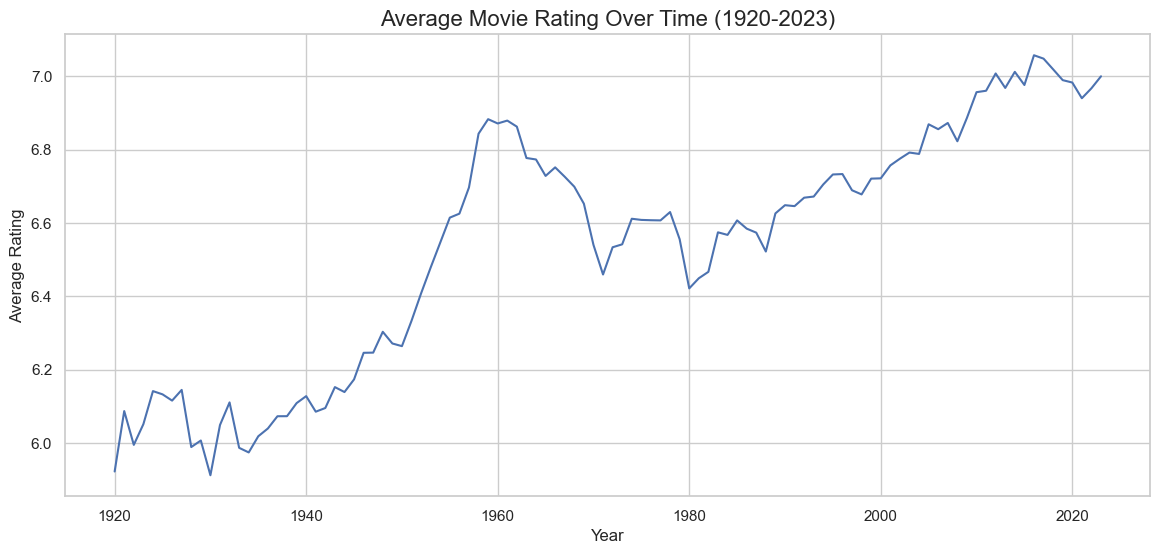

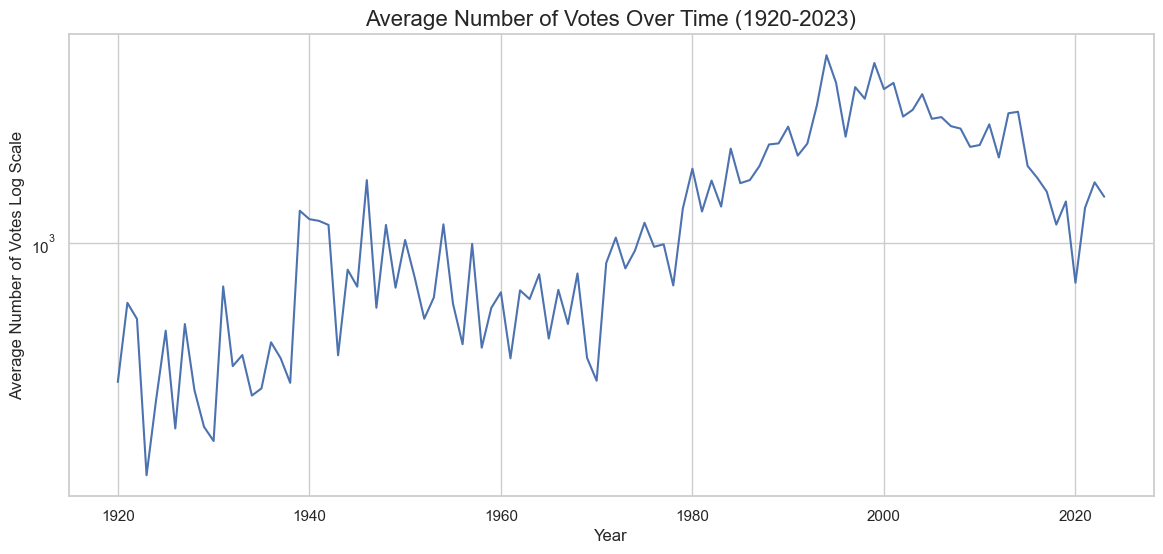

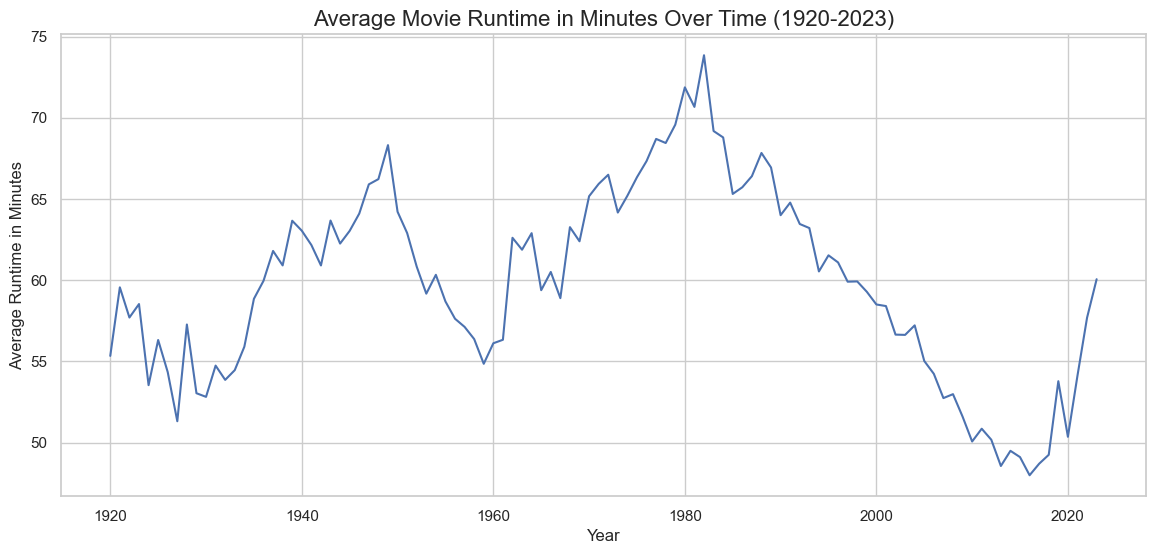

In [ ]:
print("Genre Trends Over Time (Roll-Up/Drill-Down)")
print("Fetching data for genre trends")

trends_df = get_genre_trends_over_time()

trends_df['startYear'] = pd.to_numeric(trends_df['startYear'])

trends_df_filtered = trends_df[(trends_df['startYear'] >= 1920) & (trends_df['startYear'] <= 2023)]

print("Plotting results...")

# average rating over time plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=trends_df_filtered, x='startYear', y='avg_rating')
plt.title('Average Movie Rating Over Time (1920-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

# avergae votes over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=trends_df_filtered, x='startYear', y='avg_numVotes')
plt.title('Average Number of Votes Over Time (1920-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Number of Votes Log Scale')
plt.yscale('log')
plt.show()

# average runtime over time (in minutes)
plt.figure(figsize=(14, 6))
sns.lineplot(data=trends_df_filtered, x='startYear', y='avg_runtime')
plt.title('Average Movie Runtime in Minutes Over Time (1920-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Runtime in Minutes')
plt.show()

In [32]:
print("Genre Proportions by Decade (Pivot)")
print("Calculating genre proportions")

proportions_df = get_genre_proportions_by_decade()
display(proportions_df.set_index('genreName'))

Genre Proportions by Decade (Pivot)
Calculating genre proportions
Calculating genre proportions by decade (PIVOT)...
Genre proportions query executed in 362.688 seconds, returning 29 rows.


,1870s,1880s,1890s,1900s,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
genreName,,,,,,,,,,,,,,,,
43,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Action,0.0000,0.0000,0.0010,0.0013,0.0030,0.0158,0.0174,0.0159,0.0153,0.0228,0.0248,0.0337,0.0355,0.0307,0.0267,0.0264
Adult,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,0.0002,0.0002,0.0000,0.0003,0.0061,0.0107,0.0172,0.0296,0.0311,0.0214
Adventure,0.0000,0.0000,0.0002,0.0014,0.0060,0.0185,0.0193,0.0211,0.0262,0.0318,0.0319,0.0332,0.0343,0.0281,0.0231,0.0224
Animation,0.4531,0.0220,0.0009,0.0017,0.0119,0.0482,0.0499,0.0466,0.0145,0.0288,0.0328,0.0433,0.0387,0.0368,0.0290,0.0300
Biography,0.0000,0.0000,0.0004,0.0005,0.0007,0.0021,0.0033,0.0053,0.0041,0.0047,0.0046,0.0060,0.0062,0.0073,0.0085,0.0064
Comedy,0.0000,0.0000,0.0532,0.1134,0.1748,0.1971,0.1691,0.1324,0.1207,0.1039,0.1119,0.1158,0.1344,0.1256,0.1327,0.1073
Crime,0.0000,0.0000,0.0022,0.0064,0.0133,0.0200,0.0355,0.0307,0.0345,0.0308,0.0278,0.0302,0.0324,0.0294,0.0261,0.0264
Documentary,0.0313,0.2198,0.3393,0.2295,0.0584,0.0618,0.0799,0.0900,0.0452,0.0521,0.0468,0.0554,0.0583,0.0758,0.0684,0.0653


## Statistical Tool

In [34]:
print("Z-Score Calculation")
target_movie = 'tt0468569'
target_genre = 'Action'
print(f"Calculating Z-Score for '{target_movie}' (The Dark Knight) in the '{target_genre}' genre...\n")

zscore_df = get_movie_zscore(target_movie, target_genre)

if not zscore_df.empty:
    stats = zscore_df.iloc[0]
    
    print(f"Z-Score Report for 'The Dark Knight' in Action genr")
    print(f"- Movie Rating: {stats['averageRating']:.2f}")
    print(f"- Genre Avg.: {stats['avg_rating']:.2f}")
    print(f"- Standard Dev.: {stats['stddev_rating']:.2f}")
    print(f"- Rating Z-Score: {stats['z_score_rating']:.2f}")
    
    print("\n") 
    
    print(f"- Movie Votes: {stats['numVotes']:,.0f}")
    print(f"- Genre Avg.: {stats['avg_votes']:,.0f}")
    print(f"- Standard Dev.: {stats['stddev_votes']:,.0f}")
    print(f"- Votes Z-Score: {stats['z_score_votes']:.2f}")

    print("\n")

    print("Interpretation:")
    print(f"This movie's rating is {stats['z_score_rating']:.2f} standard deviations ABOVE the average for its genre.")
    print(f"This movie's vote count is {stats['z_score_votes']:.2f} standard deviations ABOVE the average for its genre.")
else:
    print("Could not calc Z-Score")

Z-Score Calculation
Calculating Z-Score for 'tt0468569' (The Dark Knight) in the 'Action' genre...

Calculating Z-Score for tt0468569 in Action...
Z-Score query executed in 1.809 seconds.
Z-Score Report for 'The Dark Knight' in Action genr
- Movie Rating: 9.10
- Genre Avg.: 6.98
- Standard Dev.: 1.41
- Rating Z-Score: 1.50


- Movie Votes: 3,076,473
- Genre Avg.: 2,751
- Standard Dev.: 33,129
- Votes Z-Score: 92.78


Interpretation:
This movie's rating is 1.50 standard deviations ABOVE the average for its genre.
This movie's vote count is 92.78 standard deviations ABOVE the average for its genre.
